#### **load necessary packages and define path**

In [6]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join as pjoin
from had_utils import save2cifti, roi_mask
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# define path
# make sure the dataset_path are modified based on your personal dataset downloading directory
dataset_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/data_upload/HAD'
ciftify_path = pjoin(dataset_path, 'derivatives', 'ciftify')
stim_path = pjoin(dataset_path, 'stimuli')
support_path = './support_files'
# change to path of current file
os.chdir(os.path.abspath(''))

#### **Prepare the four pathways voxel index**
##### The early, lateral, ventral and dorsal pathways are defined using the surface-based Human Connectome Project-MultiModal Parcellation atlas of human cortical areas (HCP-MMP v1.0, Glasser et al. 2016). This atlas has splited the cerebral cotex into 180 areas per hemisphere and 22 regions were further clustered based on geographic proximity and functional similarities. We select appropriate ROI region for each visual pathway based on its function and geography.

In [5]:
# load roi atlas info
roi_assign = pd.read_csv(pjoin(support_path, 'HCP-MMP1_visual-cortex.csv'))
# load reference info
roi_name_path = pjoin(support_path, 'roilbl_mmp.csv')
roi_all_names = pd.read_csv(roi_name_path)
roi_index = sio.loadmat(pjoin(support_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412
# Primary_Visual and Early_Visual
EV_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([1, 2]), 'area_name'].to_list()
# Ventral_Stream_Visual, Medial_Temporal and Lateral_Temporal
VS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([4, 13, 14]), 'area_name'].to_list()
# MT+_Complex_and_Neighboring_Visual_Areas
LS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([5]), 'area_name'].to_list()
# Dorsal_Stream_Visual, Superior_Parietal, Inferior_Parietal and Posterior_Cingulate
DS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([3, 16, 17, 18]), 'area_name'].to_list()

# load template 
temp = nib.load(pjoin(support_path, 'template.dtseries.nii'))
# obtain the four pathways voxel index, including: 
# EV: early; VS: ventral; DS: dorsal; LS: lateral
region_sum = ['EV', 'VS', 'DS', 'LS']
mask_sum = np.zeros((len(region_sum), 59412), dtype=bool)
for region_idx, region in enumerate(region_sum):
    tmp_mask = roi_mask(eval(f'{region}_name'), roi_all_names, roi_index)
    print('Select %d voxels in %s'%(tmp_mask.sum(), region))
    # Save region mask
    roi_map = np.zeros((91282))
    roi_map[:59412] = tmp_mask
    save2cifti(file_path=pjoin(support_path, f'{region}.dtseries.nii'), data=roi_map, brain_models=temp)
    mask_sum[region_idx] = tmp_mask.astype(dtype=bool)


Select 4193 voxels in EV
Select 3424 voxels in VS
Select 5128 voxels in DS
Select 1349 voxels in LS


#### **load beta estimates from GLM and resort it based on desired class order**

In [9]:
# prepare params
sub_names = ['sub-%02d'%(i+1) for i in range(30)]
# sub_names = ['sub-01']
n_cycle = 4
n_sub = len(sub_names)
# prepare beta
beta_sum = np.zeros((n_sub, 180, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # extract beta in each cycle results
    beta_sub = np.zeros((4, 180, 59412))
    for cycle_idx in range(n_cycle):
        beta_sub[cycle_idx] = nib.load(pjoin(ciftify_path, sub_name, 'results', f'ses-action01_task-action_cycle-{cycle_idx+1}_beta.dscalar.nii')).get_fdata()
    beta_sub = beta_sub.mean(axis=0)
    # scale data
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)
    print(f'Finish loading beta: {sub_name}')
beta_sum = beta_sum.mean(axis=0)

# sort the class order to make categories in the same superordinate class presented adjacently
class_order = np.load(pjoin(support_path, 'class_order.npy'))
class_selected = os.listdir(stim_path)
class_selected.sort()

# resort the beta class index 
beta_sorted = np.zeros(beta_sum.shape)
for class_idx, class_name in enumerate(class_order):
    beta_sorted[class_idx] = beta_sum[class_selected.index(class_name)]

Finish loading beta: sub-01
Finish loading beta: sub-02
Finish loading beta: sub-03
Finish loading beta: sub-04
Finish loading beta: sub-05
Finish loading beta: sub-06
Finish loading beta: sub-07
Finish loading beta: sub-08
Finish loading beta: sub-09
Finish loading beta: sub-10
Finish loading beta: sub-11
Finish loading beta: sub-12
Finish loading beta: sub-13
Finish loading beta: sub-14
Finish loading beta: sub-15
Finish loading beta: sub-16
Finish loading beta: sub-17
Finish loading beta: sub-18
Finish loading beta: sub-19
Finish loading beta: sub-20
Finish loading beta: sub-21
Finish loading beta: sub-22
Finish loading beta: sub-23
Finish loading beta: sub-24
Finish loading beta: sub-25
Finish loading beta: sub-26
Finish loading beta: sub-27
Finish loading beta: sub-28
Finish loading beta: sub-29
Finish loading beta: sub-30


#### **Plot the generated RDM. The order from left to right is: Early, Ventral, Dorsal, Lateral**

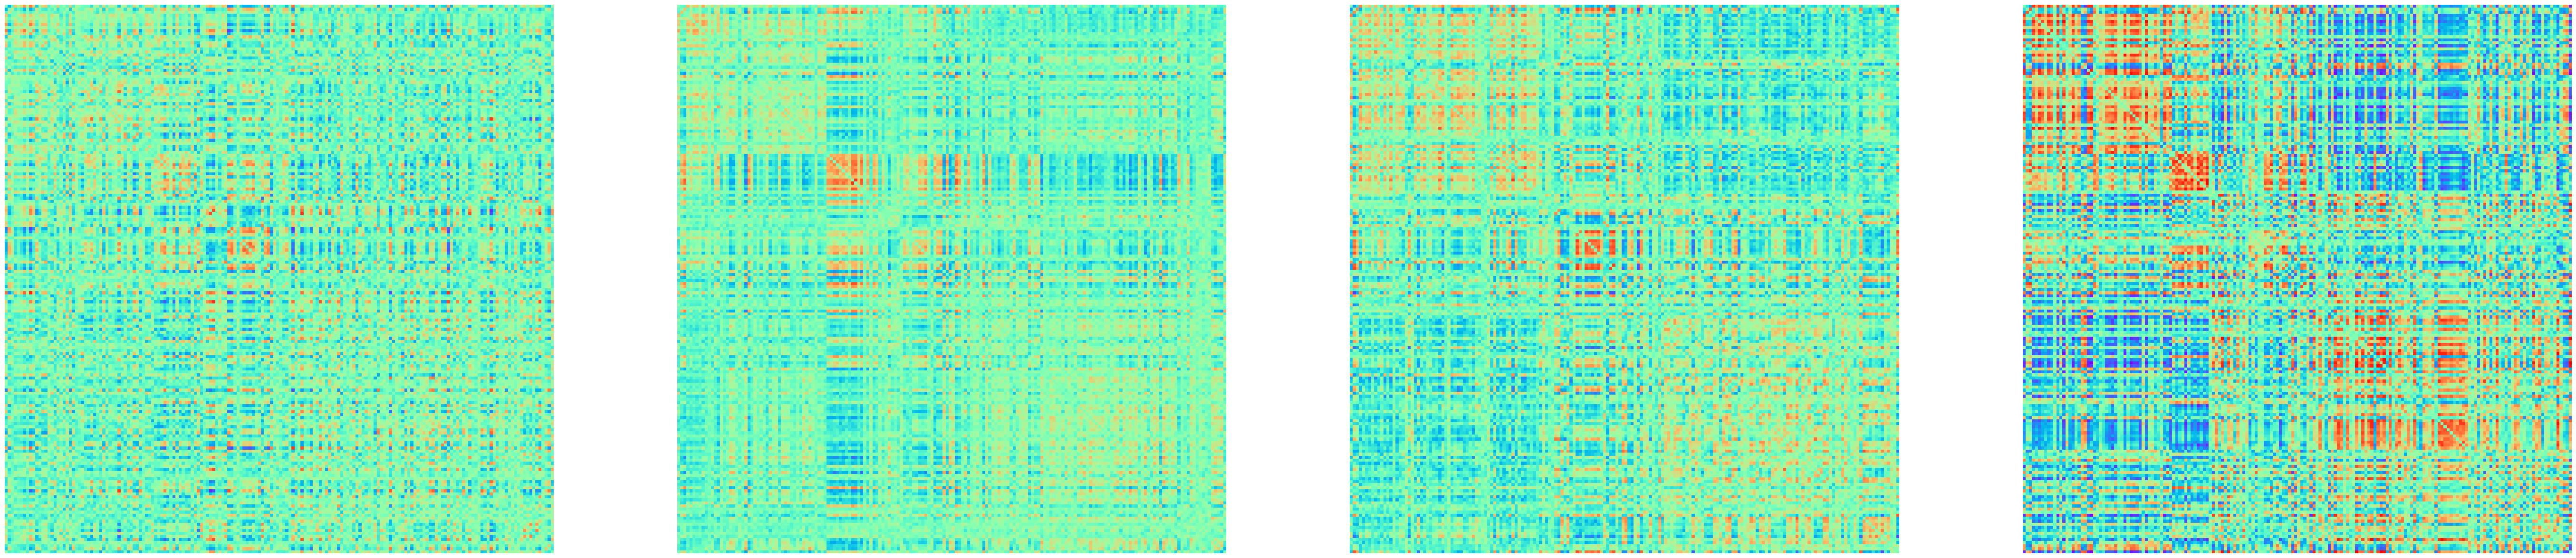

In [11]:
# define plot details
fig, ax = plt.subplots(1, len(region_sum), figsize=(70, 15))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

rdm_sum = np.zeros((len(region_sum), 180, 180))
for idx, check_roi in enumerate(region_sum):
    mask = mask_sum[idx]
    # specialized voxel loc
    class_pattern = beta_sorted[:, mask]
    # generate rdm
    rdm = np.corrcoef(class_pattern)
    np.fill_diagonal(rdm, 0)
    rdm_sum[idx] = rdm
    rdm_triu = rdm[np.triu_indices(rdm.shape[0], k=1)]
    # plot rdm 
    axes = ax[idx]
    im = axes.imshow(rdm, cmap='rainbow', vmin=-0.8, vmax=0.8) 
    axes.set_axis_off()
    
# # shown colorbar if you want
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.25)
# cbar = fig.colorbar(im, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=30)
